In [12]:
import xarray as xr
from sea_breeze import utils, load_model_data
import numpy as np
import scipy
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from skimage.measure import label, regionprops

In [21]:
#Load in BARRA-C data

lat_slice, lon_slice = utils.get_aus_bounds()

m="barra_c"
angle_ds = load_model_data.get_coastline_angle_kernel(
    compute=False,
    path_to_load="/g/data/ng72/ab4502/coastline_data/"+m+".nc",
    lat_slice=lat_slice,
    lon_slice=lon_slice
)
orog,lsm = load_model_data.load_barra_static("AUST-04",lon_slice,lat_slice)

In [3]:
from dask.distributed import Client
client = Client()
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 7
Total threads: 14,Total memory: 63.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:43529,Workers: 7
Dashboard: /proxy/8787/status,Total threads: 14
Started: Just now,Total memory: 63.00 GiB
Comm: tcp://127.0.0.1:32833,Total threads: 2
Dashboard: /proxy/34149/status,Memory: 9.00 GiB
Nanny: tcp://127.0.0.1:33431,


In [4]:
#Load in the daily SB dataset
ds = xr.open_mfdataset(
    ["/g/data/ng72/ab4502/sea_breeze_detection/barra_c_smooth_s2/filters/daily_filtered_standard_F_20000101_20241231.zarr",
     "/g/data/ng72/ab4502/sea_breeze_detection/barra_c_smooth_s2/filters/daily_filtered_standard_F_19790101_19991231.zarr"],
    combine="nested",concat_dim="time",engine="zarr").mask.sortby("time")

#Slice to just a few years
ds = ds.sel(time=slice("2019-01-01","2021-01-01")).persist()


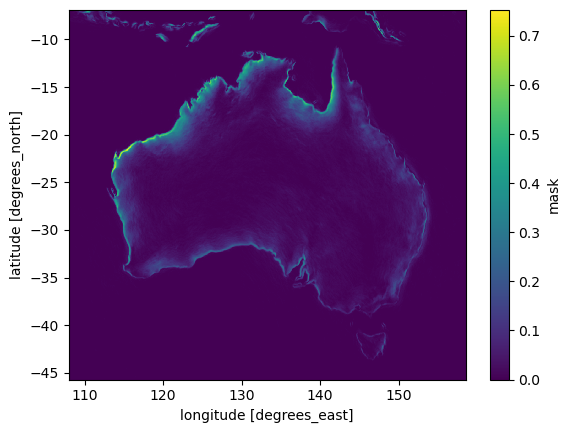

In [5]:
ds.mean("time").plot()

In [6]:
#Create an ~50 km radial max footprint

def create_elliptical_footprint(radius_y, radius_x):
    """Create an elliptical footprint with given radii for y and x directions."""
    y, x = np.ogrid[-radius_y:radius_y+1, -radius_x:radius_x+1]
    footprint = (x**2 / radius_x**2) + (y**2 / radius_y**2) <= 1
    return footprint   

#Return the size of each pixel
dx,dy,pixel_area = utils.metpy_grid_area(ds.lon,ds.lat)

#Create a footprint of 50 km 
R_km=52
radius_y = int(np.round(R_km / np.mean(dy.data)))
radius_x = int(np.round(R_km / np.mean(dx.data)))
footprint = create_elliptical_footprint(radius_y,radius_x)    

In [7]:
def process_time_slice(time_slice,**kwargs):
    """
    For using filter_2d with map_blocks
    """
    ds = scipy.ndimage.maximum_filter(time_slice.squeeze(), **kwargs)
    ds = xr.DataArray(ds,coords=time_slice.squeeze().coords).expand_dims("time")
    return ds

#Process the rolling max using map_blocks
max_ds = ds.chunk({'time':1}).map_blocks(
    process_time_slice,
    template=ds.chunk({'time':1}),
    kwargs={"footprint":footprint}).persist()
    

In [8]:
#Compute the mean over the time period for the rolling max dataset
max_ds_mean = max_ds.mean("time").persist()

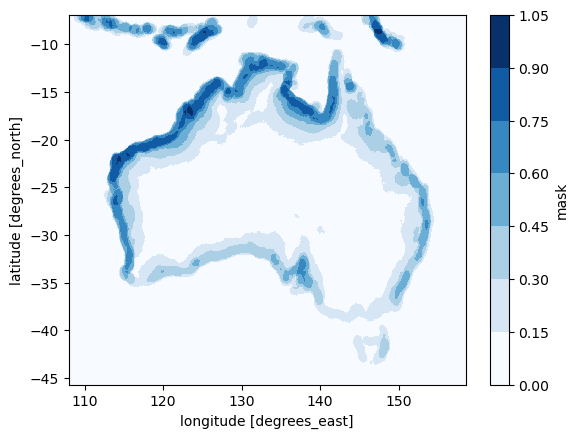

In [9]:
#And plot
max_ds_mean.plot(levels=10,cmap="Blues")

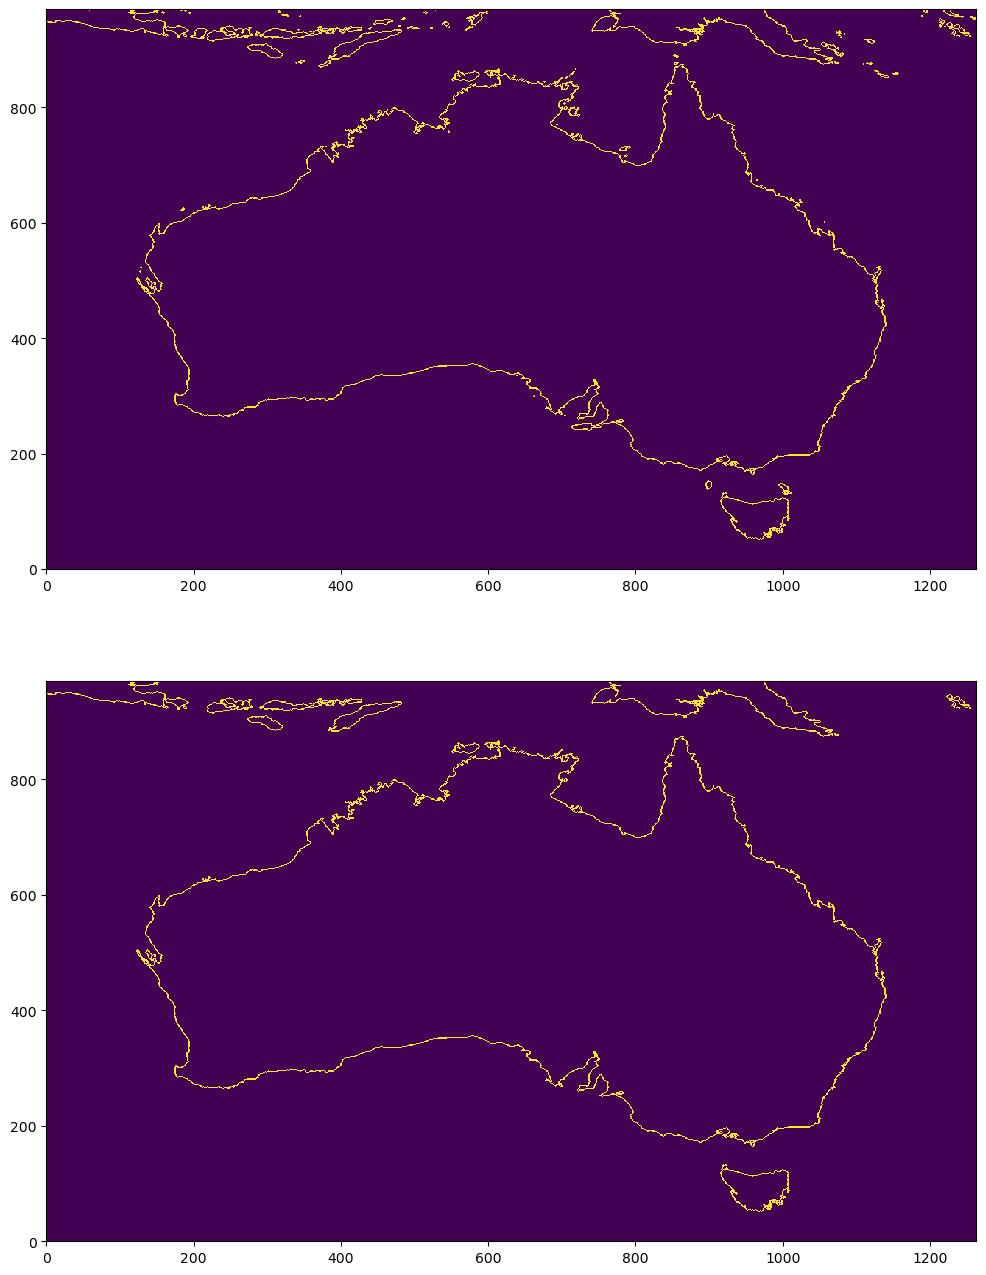

In [24]:
#Load in coastline points, and mask out small islands (defined by connected coasline points less than 200)

coast = angle_ds.coast.values

plt.figure(figsize=[12,16])
plt.subplot(2,1,1)
plt.pcolormesh(coast)

labelled_coast = label(coast)
coast_area = np.array([r.area for r in regionprops(labelled_coast)])
coast[np.isin(labelled_coast-1,np.where(coast_area < 200))] = 0

plt.subplot(2,1,2)
plt.pcolormesh(coast)


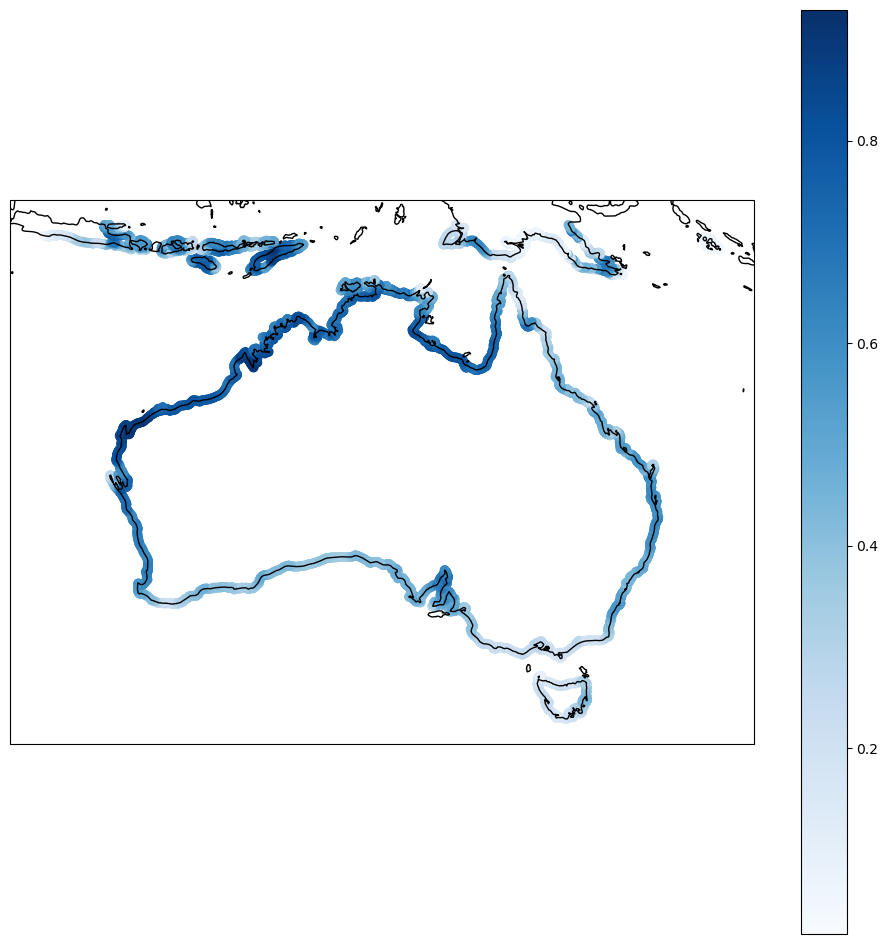

In [25]:
#Extract just these coastal points, and plot the mean SB occurrence frequency (from the rolling max dataset of objects)

xc, yc = np.where(coast)
latc = angle_ds.lat.values[xc]
lonc = angle_ds.lon.values[yc]
target_lon = xr.DataArray(lonc, dims="points")
target_lat = xr.DataArray(latc, dims="points")

meanc = max_ds_mean.sel(lon=target_lon,lat=target_lat)

plt.figure(figsize=[12,12])
ax=plt.axes(projection=ccrs.PlateCarree())
plt.scatter(lonc,latc,c=meanc,cmap="Blues",s=30)
plt.colorbar()
ax.coastlines()

In [26]:
#Now, for each point in the domain, re-project the rolling max dataset onto the closest coastline point

#Get lats and lons for the domain
lat = ds.lat.values
lon = ds.lon.values
xx,yy = np.meshgrid(lon,lat)

#Define coastal lat lons and generate a NN lookup for the domain in terms of those points
coast_x, coast_y = np.where(coast==1)
coast_lon = lon[coast_y]
coast_lat = lat[coast_x]
coast_X = np.array([coast_lat, coast_lon]).T
coast_kdt = scipy.spatial.KDTree(coast_X)
_,coast_ind = coast_kdt.query(np.array([yy.flatten(),xx.flatten()]).T, 1)
target_lon_coast = coast_lon[coast_ind.reshape((lat.shape[0],lon.shape[0]))]
target_lat_coast = coast_lat[coast_ind.reshape((lat.shape[0],lon.shape[0]))]
target_lon_coast = xr.DataArray(target_lon_coast,dims=("lat","lon"),coords={"lat":lsm.lat,"lon":lsm.lon})
target_lat_coast = xr.DataArray(target_lat_coast,dims=("lat","lon"),coords={"lat":lsm.lat,"lon":lsm.lon})

#Extract the rolling max SB object dataset as a numpy array
max_ds_vals = max_ds.values

# Convert NN target lat/lon to indices
lat_idx = xr.DataArray(np.searchsorted(max_ds.lat, target_lat_coast))
lon_idx = xr.DataArray(np.searchsorted(max_ds.lon, target_lon_coast))

#Re-index based on closes coastal point, convert to xr dataarray
max_ds_vals_nn = max_ds_vals[:,lat_idx,lon_idx]
max_ds_vals_nn = xr.DataArray(max_ds_vals_nn,coords=max_ds.coords)

Text(0.5, 1.0, 'Sea breeze object at closest coastal point (within 300 km of coast)')

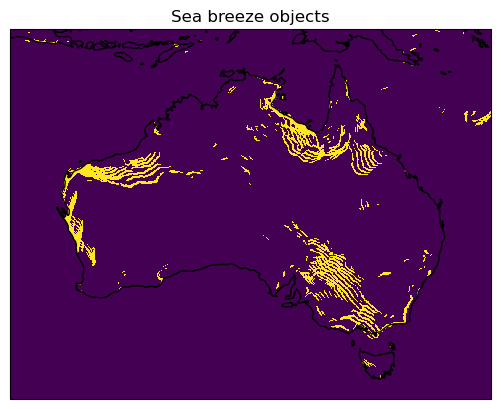

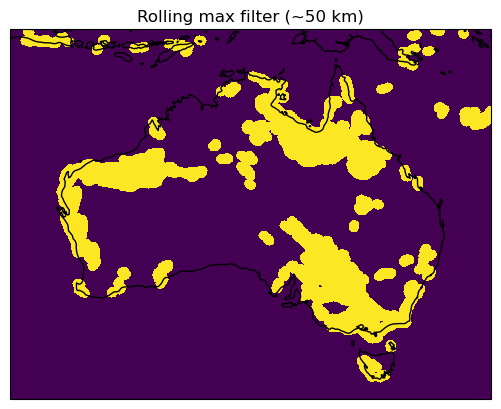

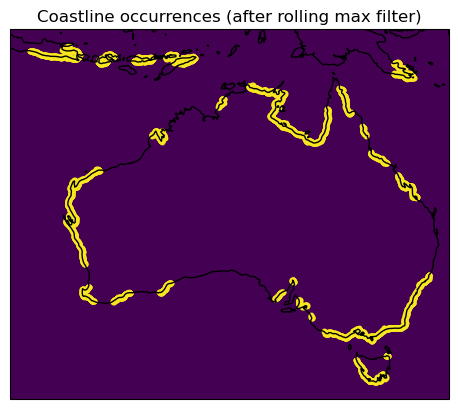

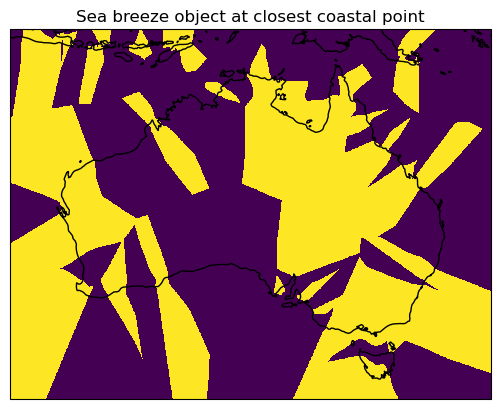

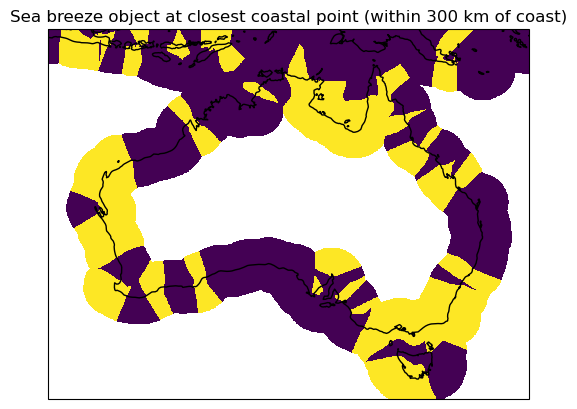

In [31]:
#Plot the steps

plt.figure()
ax = plt.axes(projection=ccrs.PlateCarree())
plt.pcolormesh(xx,yy,ds[3].values)
ax.coastlines()
plt.title("Sea breeze objects")


plt.figure()
ax = plt.axes(projection=ccrs.PlateCarree())
plt.pcolormesh(xx,yy,max_ds_vals[3])
ax.coastlines()
plt.title("Rolling max filter (~50 km)")


plt.figure()
ax = plt.axes(projection=ccrs.PlateCarree())
target_lon = xr.DataArray(lonc, dims="points")
target_lat = xr.DataArray(latc, dims="points")
coast_points = max_ds[3].sel(lon=target_lon,lat=target_lat).values
plt.scatter(
    coast_lon[coast_points],
    coast_lat[coast_points],s=10,color=plt.get_cmap("viridis")(0.99))
ax.set_facecolor(plt.get_cmap("viridis")(0))
ax.coastlines()
plt.title("Coastline occurrences (after rolling max filter)")


plt.figure()
ax = plt.axes(projection=ccrs.PlateCarree())
plt.pcolormesh(xx,yy,max_ds_vals_nn[3])
ax.coastlines()
plt.title("Sea breeze object at closest coastal point")


plt.figure()
ax = plt.axes(projection=ccrs.PlateCarree())
plt.pcolormesh(xx,yy,xr.where(angle_ds.min_coast_dist <= 300,max_ds_vals_nn[3],np.nan))
ax.coastlines()
plt.title("Sea breeze object at closest coastal point (within 300 km of coast)")


In [37]:
masked_nn = xr.where(angle_ds.min_coast_dist <= 300,max_ds_vals_nn,np.nan).persist()

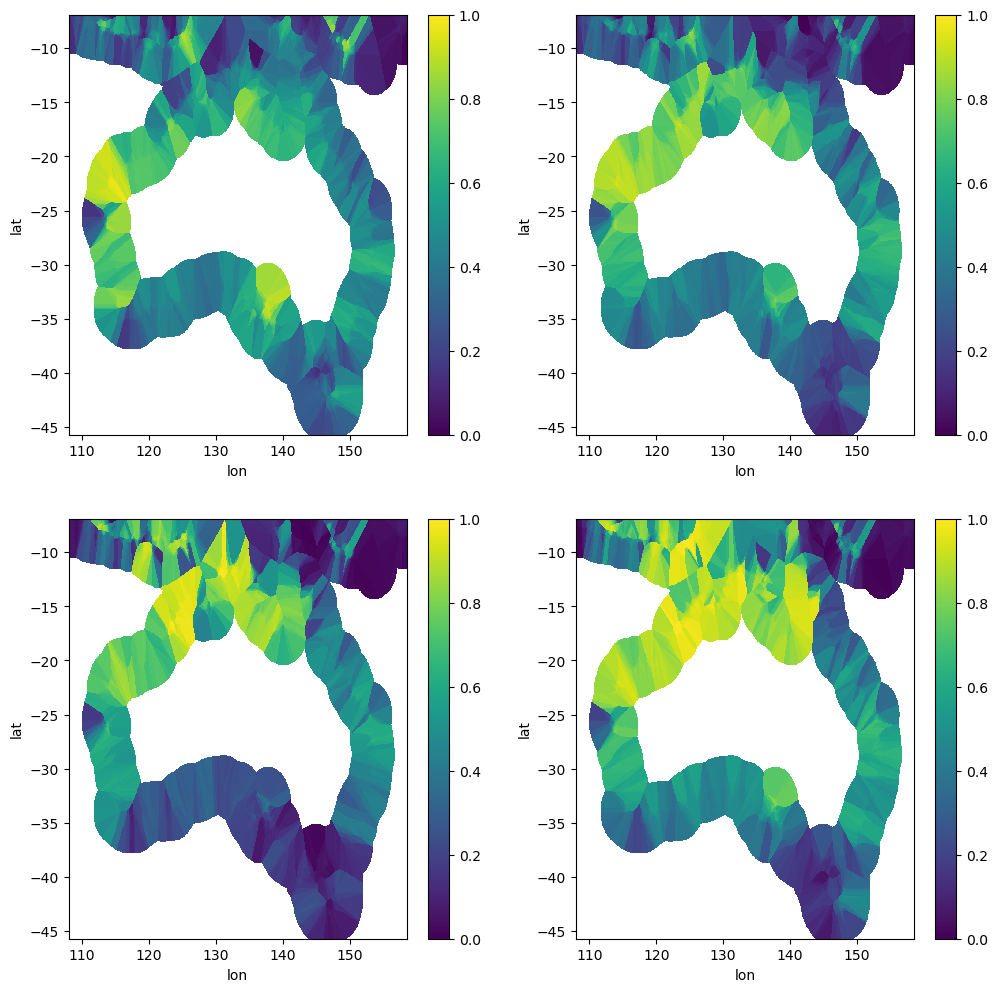

In [44]:
plt.figure(figsize=[12,12])
plt.subplot(2,2,1)
masked_nn.sel(time=np.in1d(ds.time.dt.month,[12,1,2])).mean("time").plot(vmin=0,vmax=1)

plt.subplot(2,2,2)
masked_nn.sel(time=np.in1d(ds.time.dt.month,[3,4,5])).mean("time").plot(vmin=0,vmax=1)

plt.subplot(2,2,3)
masked_nn.sel(time=np.in1d(ds.time.dt.month,[6,7,8])).mean("time").plot(vmin=0,vmax=1)

plt.subplot(2,2,4)
masked_nn.sel(time=np.in1d(ds.time.dt.month,[9,10,11])).mean("time").plot(vmin=0,vmax=1)

In [ ]:
def index_ts_dataarray(ts, target_lat, target_lon):
    """
    Index the ts DataArray using the target latitudes and longitudes.
    
    Parameters:
    * ts: xarray DataArray of the time series data
    * target_lat: 2D array of target latitudes
    * target_lon: 2D array of target longitudes
    """
    # Convert target lat/lon to indices
    lat_idx = xr.DataArray(np.searchsorted(ts.lat, target_lat))
    lon_idx = xr.DataArray(np.searchsorted(ts.lon, target_lon))
    
    # Use advanced indexing to get the values
    indexed_ts = ts.isel(lat=lat_idx, lon=lon_idx)
    
    return indexed_ts

#F_filtered_coastal = xr.concat(temp_filtered_coastal_ls,dim="date")
coast_selected_ls = []

import tqdm
#for i in tqdm.tqdm(np.arange(max_ds.time.shape[0])):
for i in tqdm.tqdm(np.arange(0,10)):
    coast_selected = xr.DataArray(
        index_ts_dataarray(
            max_ds.isel(time=i),target_lat_coast,target_lon_coast),
        dims=max_ds.isel(time=i).dims,coords=max_ds.isel(time=i).coords)
    coast_selected_ls.append(coast_selected)

#index_ts_dataarray(max_ds.isel(time=slice(3,5)), target_lat_coast, target_lon_coast)

  0%|          | 0/10 [00:00<?, ?it/s]/g/data/xp65/public/apps/med_conda/envs/analysis3-24.07/lib/python3.11/site-packages/distributed/client.py:3371: UserWarning: Sending large graph of size 50.12 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


In [ ]:
import tqdm

#For each day, take the rolling maximum over a 50 km radius, and mask out points that are further from 50 km from the coast
temp_filtered_coastal_ls = []
for i in tqdm.tqdm(np.arange(ds.date.shape[0])):

    temp = ds.isel(date=i)
    
    temp_filtered = xr.DataArray(
            scipy.ndimage.maximum_filter(temp.mask,footprint=footprint),
            coords=temp.coords, dims=temp.dims)
    temp_filtered_coastal = xr.where(
        angle_ds.min_coast_dist <= 50,
        temp_filtered,
        0)
    temp_filtered_coastal_ls.append(temp_filtered_coastal)

# plt.figure(figsize=[12,5])
# ax=plt.subplot(1,2,1,projection=ccrs.PlateCarree())
# xr.where(angle_ds.sel(lon=slice(108,158.5)).min_coast_dist<=20,
# xr.DataArray(
#         scipy.ndimage.maximum_filter(temp.mask,footprint=footprint),
#         coords=temp.coords, dims=temp.dims),
#          0).plot()
# ax.coastlines(lw=0.5)


# ax=plt.subplot(1,2,2,projection=ccrs.PlateCarree())
# temp.mask.plot()
# ax.coastlines(lw=0.5)

100%|██████████| 178/178 [00:03<00:00, 44.98it/s]


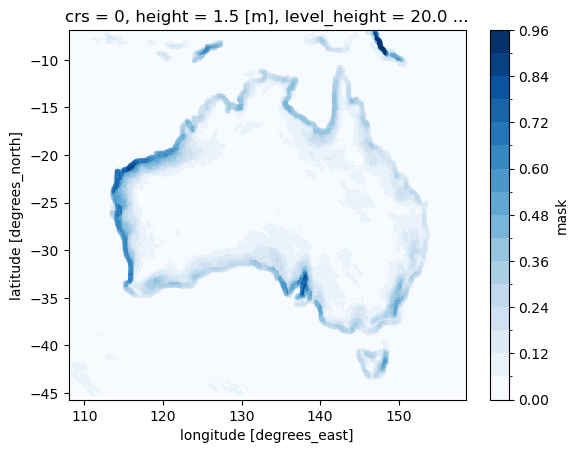

In [25]:
rolling_max = ds.mask.rolling({"lat":4,"lon":4}).max().mean("date").persist()
rolling_max.plot(cmap="Blues",levels=20)

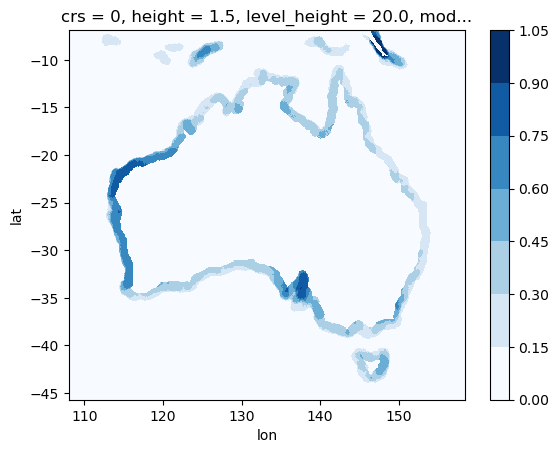

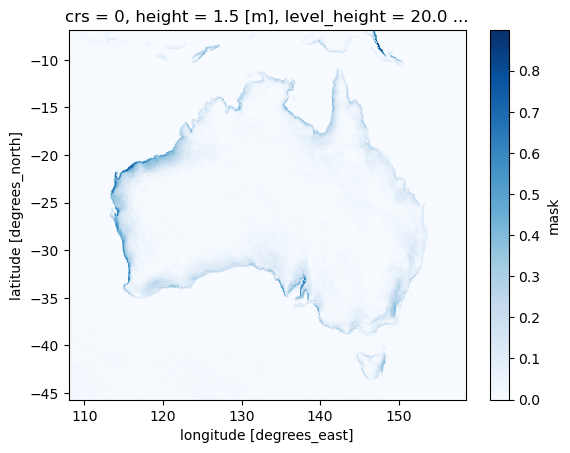

In [6]:
plt.figure()
xr.concat(temp_filtered_coastal_ls,dim="date").mean("date").plot(cmap="Blues",levels=10)

plt.figure()
ds.mask.mean("date").plot(cmap="Blues")

In [24]:
brisbane_lat, brisbane_lon = -27.5716, 153.0071   #0.30 sb/day (Soderholm)
adelaide_lat, adelaide_lon = -34.9524, 138.5196   #0.42 sb/day (Masouleh)
perth_lat, perth_lon = -31.9275, 115.9764         #0.66 sb/day (Rafiq, based on Masselink)

print(rolling_max.sel(lat=brisbane_lat,lon=brisbane_lon,method="nearest").values)
print(rolling_max.sel(lat=adelaide_lat,lon=adelaide_lon,method="nearest").values)
print(rolling_max.sel(lat=perth_lat,lon=perth_lon,method="nearest").values)

0.1348314606741573
0.4438202247191011
0.601123595505618


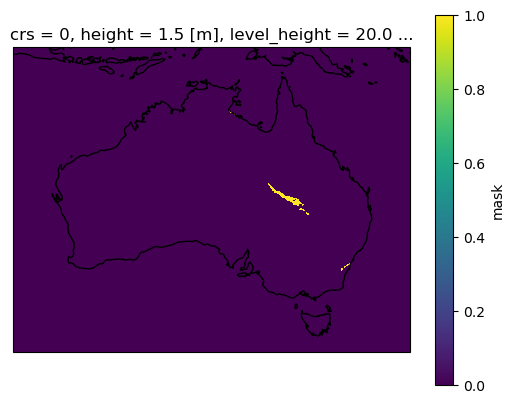

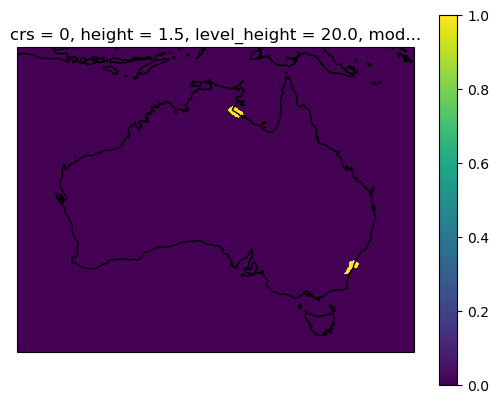

In [98]:
ax = plt.axes(projection=ccrs.PlateCarree())
temp.mask.plot()
ax.coastlines()

plt.figure()
ax = plt.axes(projection=ccrs.PlateCarree())
temp_filtered_coastal.plot()
ax.coastlines()

In [99]:
lat = ds.lat.values
lon = ds.lon.values
xx,yy = np.meshgrid(lon,lat)

coast_x, coast_y = np.where(angle_ds.coast==1)
coast_lon = lon[coast_y]
coast_lat = lat[coast_x]
coast_X = np.array([coast_lat, coast_lon]).T
coast_kdt = scipy.spatial.KDTree(coast_X)

_,coast_ind = coast_kdt.query(np.array([yy.flatten(),xx.flatten()]).T, 1)
target_lon_coast = coast_lon[coast_ind.reshape((lat.shape[0],lon.shape[0]))]
target_lat_coast = coast_lat[coast_ind.reshape((lat.shape[0],lon.shape[0]))]
target_lon_coast = xr.DataArray(target_lon_coast,dims=("lat","lon"),coords={"lat":lsm.lat,"lon":lsm.lon})
target_lat_coast = xr.DataArray(target_lat_coast,dims=("lat","lon"),coords={"lat":lsm.lat,"lon":lsm.lon})

def index_ts_dataarray(ts, target_lat, target_lon):
    """
    Index the ts DataArray using the target latitudes and longitudes.
    
    Parameters:
    * ts: xarray DataArray of the time series data
    * target_lat: 2D array of target latitudes
    * target_lon: 2D array of target longitudes
    """
    # Convert target lat/lon to indices
    lat_idx = xr.DataArray(np.searchsorted(ts.lat, target_lat))
    lon_idx = xr.DataArray(np.searchsorted(ts.lon, target_lon))

    # Use advanced indexing to get the values
    indexed_ts = ts.isel(lat=lat_idx, lon=lon_idx).values
    
    return indexed_ts

F_filtered_coastal = xr.concat(temp_filtered_coastal_ls,dim="date")
coast_selected_ls = []

for i in tqdm.tqdm(np.arange(ds.date.shape[0])):
    coast_selected = xr.DataArray(
        index_ts_dataarray(
            F_filtered_coastal.isel(date=i),target_lat_coast,target_lon_coast),
        dims=F_filtered_coastal.isel(date=i).dims,coords=F_filtered_coastal.isel(date=i).coords)
    coast_selected_ls.append(coast_selected)

100%|██████████| 181/181 [00:01<00:00, 111.70it/s]


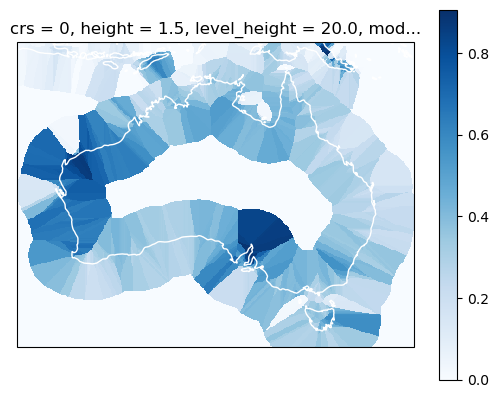

In [110]:
plt.figure()
ax = plt.axes(projection=ccrs.PlateCarree())
xr.where(
    angle_ds.min_coast_dist<=500,
    xr.concat(coast_selected_ls,dim="date").mean("date"),
    0).plot(cmap="Blues")
ax.coastlines(color="w")




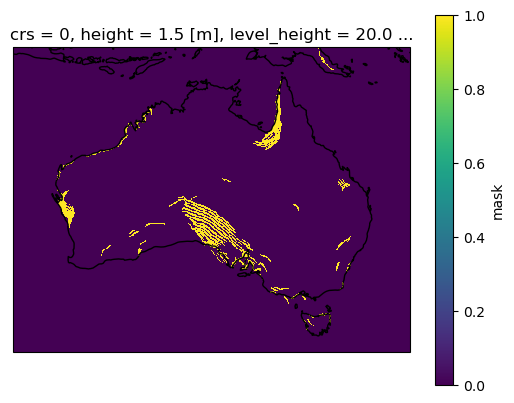

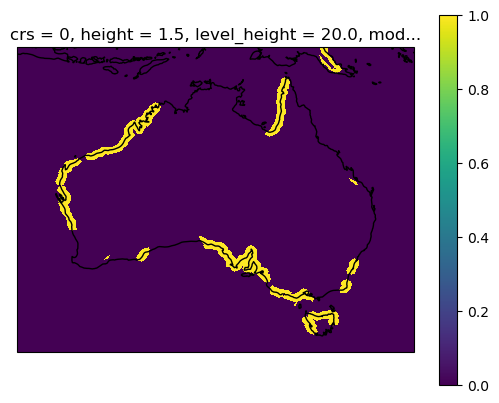

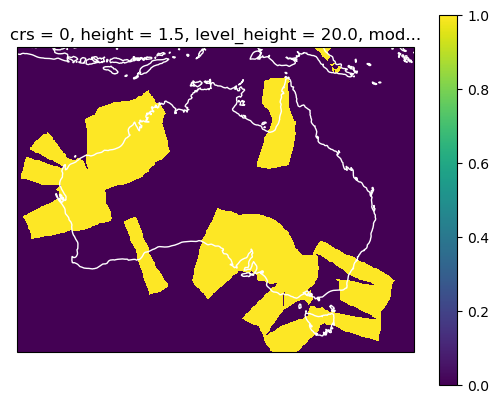

In [87]:
ax = plt.axes(projection=ccrs.PlateCarree())
temp.mask.plot()
ax.coastlines()

plt.figure()
ax = plt.axes(projection=ccrs.PlateCarree())
temp_filtered_coastal.plot()
ax.coastlines()

plt.figure()
ax = plt.axes(projection=ccrs.PlateCarree())
xr.where(
    angle_ds.min_coast_dist<=500,
    coast_selected,
    0).plot()
ax.coastlines(color="w")

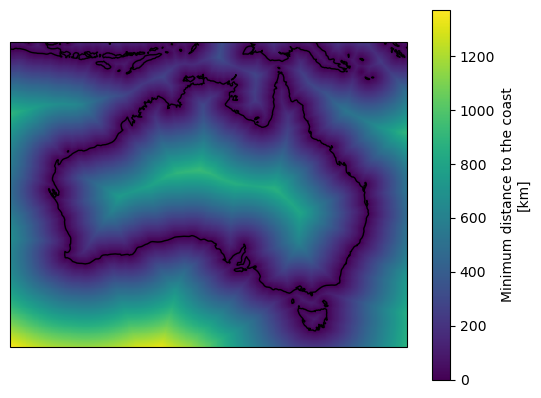

In [65]:
plt.figure()
ax = plt.axes(projection=ccrs.PlateCarree())
angle_ds.min_coast_dist.plot()
ax.coastlines()

In [20]:
xc, yc = np.where(angle_ds.coast)
latc = angle_ds.lat[xc]
lonc = angle_ds.lon[yc]

In [25]:
import pyproj

In [26]:
geod = pyproj.Geod(ellps="WGS84")

In [28]:
geod.inv(lonc[0],latc[0],angle_ds.lon.values,angle_ds.lat.values)

GeodError: Array lengths are not the same.